In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
import seaborn as sb
import flask
import time
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%matplotlib inline
plt.style.use('ggplot')
full_df = pd.read_csv(r"C:\Users\Nicz\Documents\GitHub\3204-CourseWork2\shuffled-noIPV6.csv")
# full_df = pd.read_csv(r"fortf.csv")

print(f"[*] Shape of dataset: {full_df.shape}")
from sklearn.utils import shuffle
full_df.drop(full_df.columns[0], axis=1, inplace=True)
full_df = shuffle(full_df)

print(full_df.tail())
print("\n")

[*] Shape of dataset: (92704, 15)
       @timestamp           src_ip src_port         dst_ip dst_port Protocol  \
75409  1666591347        10.0.0.20    33852      10.0.0.21     3306    mysql   
74898  1666722170     172.24.2.11         0   172.24.2.100        0     HTTP   
66988  1666580391  192.168.207.142        0              0        0    HTTPS   
77721  1666692065      10.32.4.176    46492  10.132.100.52       80      TCP   
62816  1666692055    100.64.19.103    44618   100.64.19.22     8443      TCP   

      http_request_method http_request_referrer http_response_code  \
75409                   0                     0                  0   
74898                 GET                     0                404   
66988                 GET                     0                404   
77721                   0                     0                  0   
62816                   0                     0                  0   

             url_path user_agent_original sql_method  \
75409   

In [4]:
full_df["src_port"]=  full_df["src_port"].replace(regex=",", value= "")
full_df["src_port"]=  full_df["src_port"].replace(regex=",", value= "")
full_df["dst_port"]=  full_df["dst_port"].replace(regex=",", value= "")
full_df["dst_port"]=  full_df["dst_port"].replace(regex=" ", value= "")
full_df["src_port"] = full_df["src_port"].replace(regex=" ", value="")
full_df["src_port"] = full_df["src_port"].replace(regex="dns", value="53")
full_df["src_port"] = full_df["src_port"].replace(regex="tls", value="0")
full_df["dst_port"] = full_df["dst_port"].replace(regex="dns", value="53")
full_df["dst_ip"] = full_df["dst_ip"].replace(regex="\S*:+\S+", value="0")

In [5]:
scores = {}
scores_list= []

k_value=[]
model_scores={}
accuracy_dict={}
precision_dict={}
cm_dict={}
recall_dict={}
f1_dict={}

algo_accuracy={}
algo_precision={}
algo_recall={}
algo_f1={}

def scoring_metrics(y_test, y_pred, model):
    print(f"y_test size:{y_test.size} y_pred size:{y_pred.size}")
    KNN_accuracy = metrics.accuracy_score(y_test, y_pred)
    KNN_precision = metrics.precision_score(y_test, y_pred, average="weighted")
    KNN_recall = metrics.recall_score(y_test, y_pred, average="weighted")
    KNN_f1_score = metrics.f1_score(y_test, y_pred, average="weighted")
    
    scores[model] = KNN_accuracy
    scores_list.append(KNN_accuracy)
    cm = metrics.confusion_matrix(y_test, y_pred, labels=['ldap_enumeration','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration'])
    
    k_value.append(model)
    accuracy_dict[model]= KNN_accuracy
    precision_dict[model]= KNN_precision
    recall_dict[model]= KNN_recall
    f1_dict[model]= KNN_f1_score
           
    print(f"Confusion Matrix: {cm}")
    
    print(f"\n[*] Model: {model}")
    print("[*]Precision: {:.3f}%".format(KNN_precision))
    print("[*] Recall: {:.3f}%".format(KNN_recall))

    print("[*] Accuracy: {:.3f}%".format(KNN_accuracy))
    print("[*] F1_score: {:.3f}%".format(KNN_f1_score))


# KNN

In [6]:
df = full_df.head(25000)

In [7]:
print("Doing")
from sklearn.preprocessing import OneHotEncoder
df.replace(to_replace=["None"], value=np.nan, inplace=True)
clean_df = df.fillna(str(0)) #uhm i dont knowhow to explain this, but please lmk another alternative to fix this cause :") try to run it without str and you will know what i mean"
clean_x = clean_df.iloc[:, :13].values
clean_y = clean_df["category"].values
features = df.columns.values[:-1]

for label in clean_df.columns:
    for index, rows in clean_df.iterrows():
        new_ip = ""
        ip = str(rows[label])
        if re.search("\d+\.\d+\.\d+\.\d+", ip):
            octets = ip.split(".")
            for octet in octets:
                octet = octet.rjust(3,"0")
                new_ip += octet
            clean_df[label][index] = new_ip

clean_df["http_response_code"] = clean_df["http_response_code"].replace('HTTP/1.1"', value="0")
clean_df["src_ip"] = clean_df["src_ip"].replace('::1', value="0")
clean_df["dst_ip"] = clean_df["dst_ip"].replace('::1', value="0")
# clean_df["http_response_code"] = clean_df["http_response_code"].replace('HTTP/1.1"', value="0")
print("Done")

Doing


C:\Users\Nicz\AppData\Local\Temp\ipykernel_51060\1930992280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(to_replace=["None"], value=np.nan, inplace=True)
C:\Users\Nicz\AppData\Local\Temp\ipykernel_51060\1930992280.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[label][index] = new_ip


Done


In [8]:
clean_x = clean_df.iloc[:, :13] #honestly don't know if this is correct lmaoooo
#this is to iterate through the columns and convert the strings to float (passthrough means for those columns we didnt specify, leave it as it is)
column_trans = make_column_transformer((OneHotEncoder(sparse=False), ['Protocol', 'http_request_method', 'http_request_referrer', 'url_path', 'user_agent_original', 'sql_method', 'sql_query']),remainder='passthrough')
test = column_trans.fit_transform(clean_x) #this is technically our cl

In [9]:
x_train, x_test, y_train, y_test = train_test_split(test, clean_y, test_size=0.3)
# x_variable_train , x_variable_test , y_variable_train , y_variable_test  = train_test_split(test, clean_y, test_size=0.3)

In [21]:
scores = {}
scores_list= []
ktrainingtime={}
kpredictiontime={}

range_k = range(100, 160, 11)
knn = ""
skip = False

for k in range_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    start_time = time.time()
    knn.fit(x_train, y_train)
    timetaken = time.time() - start_time
    ktrainingtime[k] = timetaken
    
    timetaken = 0 
    
    start_time = time.time()
    y_pred = knn.predict(x_test)
    timetaken = time.time() - start_time
    kpredictiontime[k] = timetaken
    
    scoring_metrics(y_test, y_pred, f"{k}")
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    
print(ktrainingtime)
print(kpredictiontime)

y_test size:7500 y_pred size:7500
Confusion Matrix: [[   0    0    0    0    0    0]
 [   0  692    0    0    0    0]
 [   0    0 3553    4   13    0]
 [   0    0    3   35    0    0]
 [   0    0    7    0  925    0]
 [   0    0   42   15    1 2210]]

[*] Model: 100
[*]Precision: 0.989%
[*] Recall: 0.989%
[*] Accuracy: 0.989%
[*] F1_score: 0.989%
y_test size:7500 y_pred size:7500
Confusion Matrix: [[   0    0    0    0    0    0]
 [   0  692    0    0    0    0]
 [   0    0 3552    4   14    0]
 [   0    0    3    0    0   35]
 [   0    0    7    0  925    0]
 [   0    0   42    4    1 2221]]

[*] Model: 111
[*]Precision: 0.981%
[*] Recall: 0.985%
[*] Accuracy: 0.985%
[*] F1_score: 0.983%
y_test size:7500 y_pred size:7500
Confusion Matrix: [[   0    0    0    0    0    0]
 [   0  692    0    0    0    0]
 [   0    0 3551    4   15    0]
 [   0    0    3    0    0   35]
 [   0    0    7    0  925    0]
 [   0    0   19    4   24 2221]]

[*] Model: 122
[*]Precision: 0.981%
[*] Recall: 0.

c:\users\nicz\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
#dictionary to store processing times
algotrainingtime = {}
algopredictiontime = {}

clf = RandomForestClassifier(criterion="gini",
                             min_samples_split = 20,
                             min_samples_leaf = 6,
                             max_depth = 100,
                             n_estimators=500,
                             random_state=5) #can put any number here
start_time =time.time()
clf.fit(x_train, y_train)
rftrainingtimetaken = time.time() - start_time
algotrainingtime["Random Forest"] = rftrainingtimetaken

start_time =time.time()
y_pred = clf.predict(x_test)
rfpredictiontimetaken = time.time() - start_time
algopredictiontime["Random Forest"] = rfpredictiontimetaken

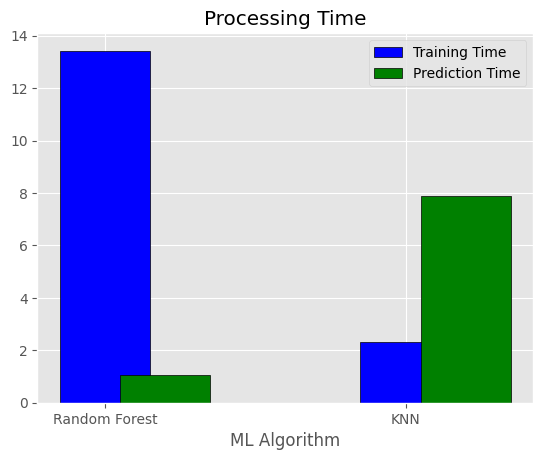

In [47]:
#Update the algotime dictionaries with KNN's results
algotrainingtime["KNN"] = ktrainingtime[133]
algopredictiontime["KNN"] = kpredictiontime[133]

#Plot the processing time graphs
plt.title('Processing Time')
plt.xlabel('ML Algorithm')

trainingtime = algotrainingtime.values()
predictiontime = algopredictiontime.values()

x_axis = np.arange(len(algotrainingtime))
width = 0.2
#multi bar charts
plt.bar(x_axis, trainingtime, color = 'b', width = 0.3, edgecolor = 'black',label='Training Time')
plt.bar(x_axis + width, predictiontime, color = 'g',width = 0.3, edgecolor ='black',label='Prediction Time')

plt.xticks(x_axis,algotrainingtime.keys())
plt.legend(loc="upper right")
plt.savefig('ProcessingTime_Comparison.png')
plt.show()

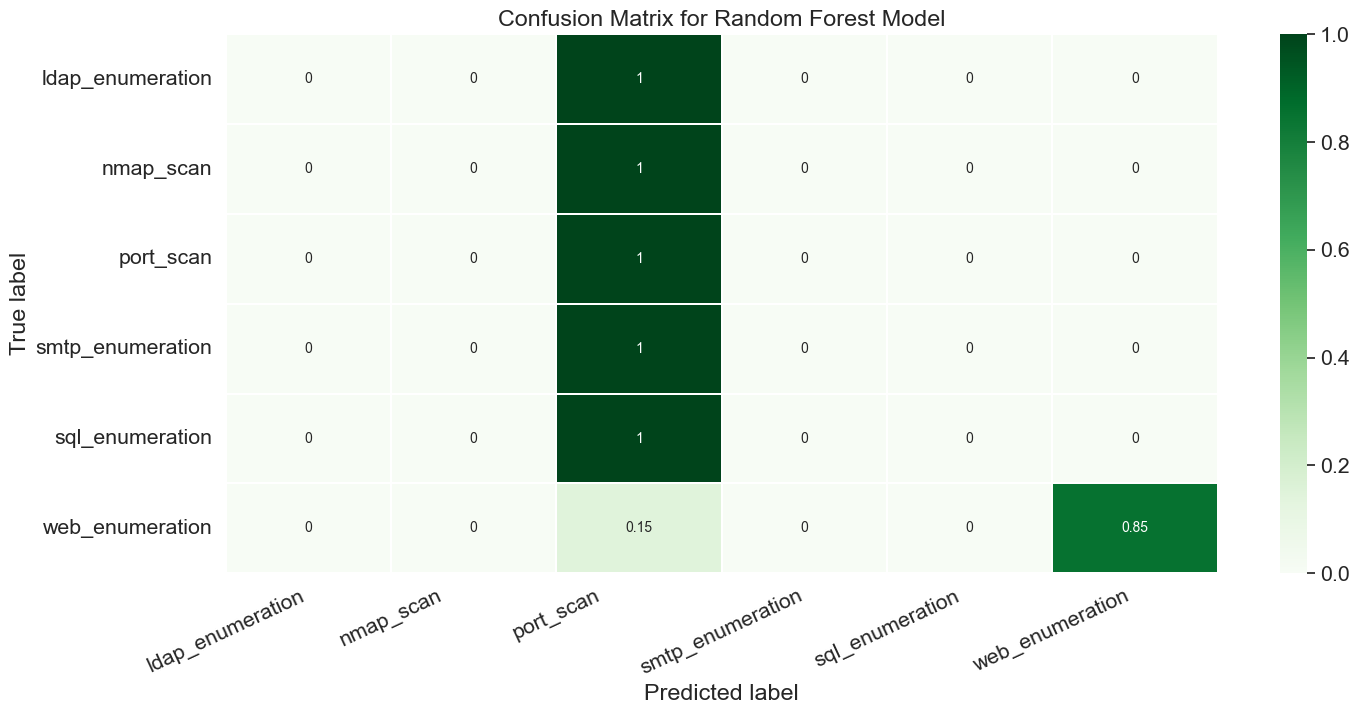

Classification Report 
 {'ldap_enumeration': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'nmap_scan': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'port_scan': {'precision': 1.0, 'recall': 0.639770485924332, 'f1-score': 0.7803171131765992, 'support': 5577}, 'smtp_enumeration': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'sql_enumeration': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'web_enumeration': {'precision': 0.8523936170212766, 'recall': 1.0, 'f1-score': 0.9203158650394831, 'support': 1923}, 'accuracy': 0.7321333333333333, 'macro avg': {'precision': 0.3087322695035461, 'recall': 0.2732950809873887, 'f1-score': 0.2834388297026804, 'support': 7500}, 'weighted avg': {'precision': 0.9621537234042553, 'recall': 0.7321333333333333, 'f1-score': 0.8162127931542427, 'support': 7500}}


c:\users\nicz\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nicz\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nicz\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score,recall_score
from sklearn.metrics import confusion_matrix

## ==== CONFUSION MATRIX ====
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sb.set(font_scale=1.4)
sb.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ldap_enumeration','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

RF_accuracy= accuracy_score(y_test, y_pred)
algo_accuracy["Random Forest"]= RF_accuracy

RF_precision = precision_score(y_test, y_pred,average="weighted")
algo_precision["Random Forest"] = RF_precision

R1_f1_score = f1_score(y_test, y_pred,average="weighted")
algo_f1["Random Forest"]=R1_f1_score

R1_recall = recall_score(y_test, y_pred,average="weighted")
algo_recall["Random Forest"]=R1_recall

print("Classification Report \n" , classification_report(y_pred, y_test, labels=['ldap_enumeration','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration'], output_dict=True))
#print("Accuracy Score:\n",(accuracy_score(y_test, y_pred)))
#print("Precision Score:\n",(precision_score(y_test, y_pred,average="weighted")))
#print("Precision Score:\n",(f1_score(y_test, y_pred,average="weighted")))


C:\Users\Nicz\AppData\Local\Temp\ipykernel_70868\1059628183.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=45)


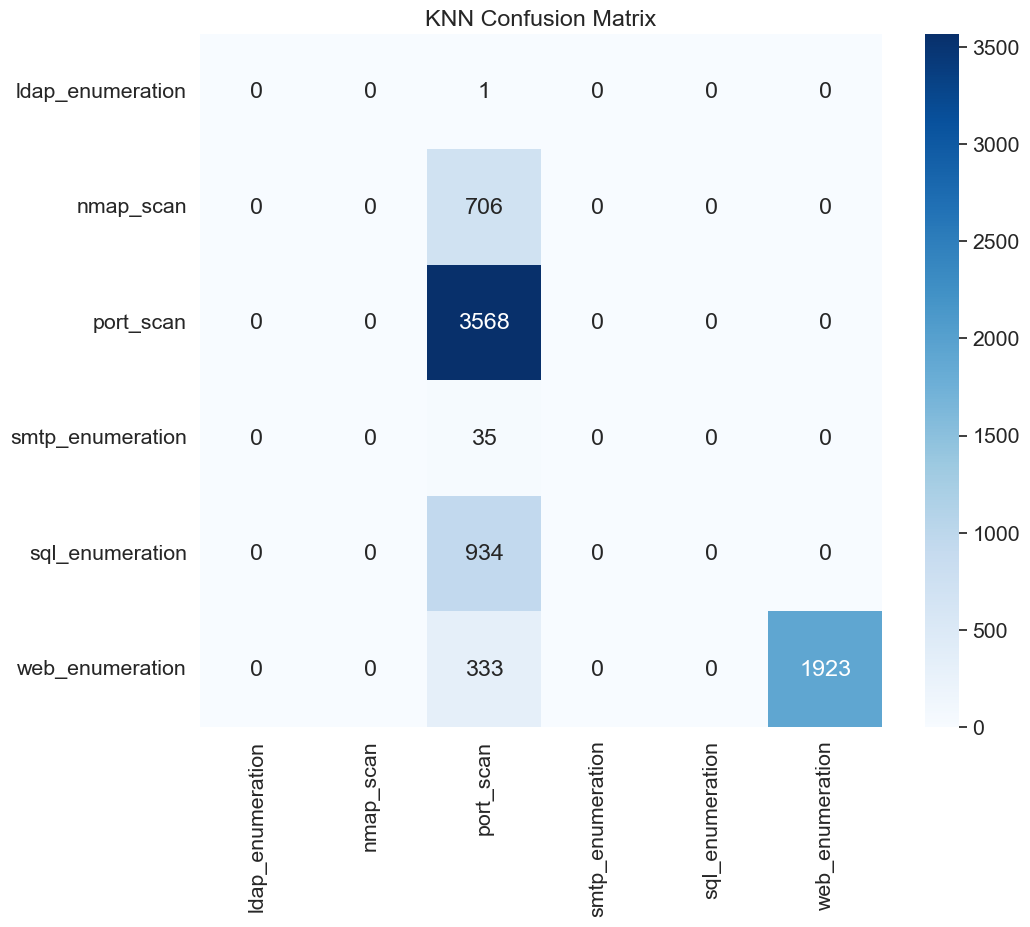

In [21]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(11, 9))

categories = ['ldap_enumeration','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration']
ax.set_xticklabels(categories, rotation=45)
                   
sb.heatmap(confusion_matrix, annot=True, fmt='0', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('KNN Confusion Matrix')
plt.savefig('KNN_ConfusionMatrix.png')

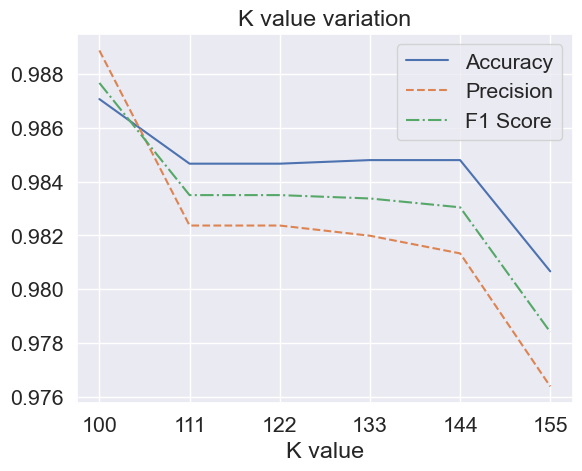

In [29]:
plt.title('K value variation')
plt.xlabel('K value')

k_value = list(accuracy_dict.keys())

algo_accuracy["KNN"]= accuracy_dict['133']
plt.plot(k_value, accuracy_dict.values(), label = "Accuracy", linestyle="-")
plt.plot(k_value, precision_dict.values(), label = "Precision", linestyle="--")
plt.plot(k_value, f1_dict.values(), label = "F1 Score", linestyle="-.")

plt.legend(loc="upper right")
plt.savefig('KNN_graph.png')
plt.show()

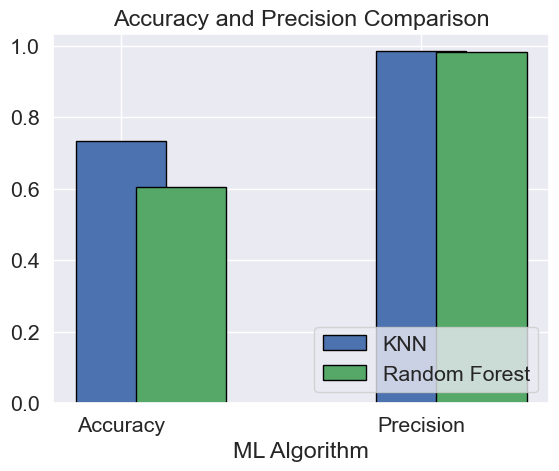

In [46]:
plt.title('Accuracy and Precision Comparison')
plt.xlabel('ML Algorithm')

#Defining data to display
algo_accuracy["KNN"]= accuracy_dict['133']
algo_precision['KNN']= precision_dict['133']

accuracy = algo_accuracy.values()
precision = algo_precision.values()
x_axis = np.arange(len(algo_accuracy))
width = 0.2

#multi bar charts
plt.bar(x_axis, accuracy, color = 'b', width = 0.3, edgecolor = 'black',label='KNN')
plt.bar(x_axis + width, precision, color = 'g',width = 0.3, edgecolor ='black',label='Random Forest')

plt.xticks(x_axis,['Accuracy', 'Precision'])
plt.legend(loc='lower right')
plt.savefig('AnP_Comparison.png')
plt.show()

dict_values([0.7321333333333333, 0.9848])
dict_keys(['Random Forest', 'KNN'])


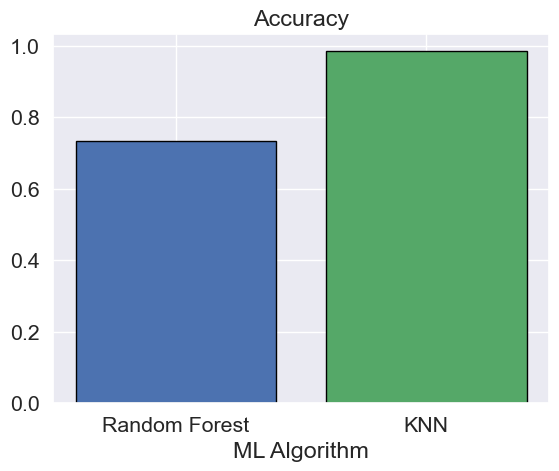

In [47]:
plt.title('Accuracy')
plt.xlabel('ML Algorithm')
#k_value = list(accuracy_dict.keys())
algo_accuracy["KNN"]= accuracy_dict['133']
accuracy = algo_accuracy.values()
print(accuracy)
print(algo_accuracy.keys())
x_axis = algo_accuracy.keys()
plt.bar(x_axis, accuracy,edgecolor = 'black', color=['b', 'g'])

plt.savefig('Accuracy_comparison.png')
plt.show()

dict_values([0.6051601458370689, 0.9819903282212875])
dict_keys(['Random Forest', 'KNN'])


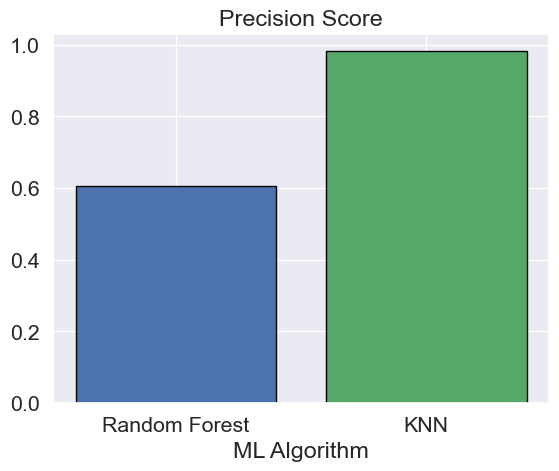

In [48]:
plt.title('Precision Score')
plt.xlabel('ML Algorithm')

algo_precision["KNN"]= precision_dict['133']
precisionscores = algo_precision.values()
print(precisionscores)
x_axis = algo_precision.keys()
print(x_axis)
plt.bar(x_axis, precisionscores,edgecolor = 'black', label = "F1 Scores", color=['b', 'g'])

plt.savefig('precision_comparison.png')
plt.show()

dict_values([0.648053873512424, 0.9833739348644424])
dict_keys(['Random Forest', 'KNN'])


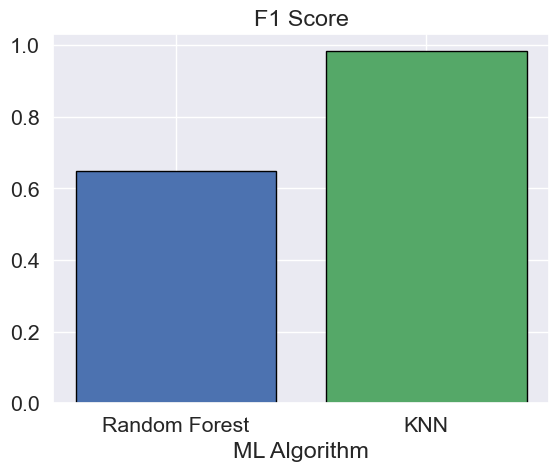

In [49]:
plt.title('F1 Score')
plt.xlabel('ML Algorithm')

algo_f1["KNN"]= f1_dict['133']
f1_scores = algo_f1.values()
print(f1_scores)
x_axis = algo_f1.keys()
print(x_axis)
plt.bar(x_axis, f1_scores,edgecolor = 'black', label = "F1 Scores", color=['b', 'g'])

plt.savefig('F1_comparison.png')
plt.show()

dict_values([0.7321333333333333, 0.9848])
dict_keys(['Random Forest', 'KNN'])


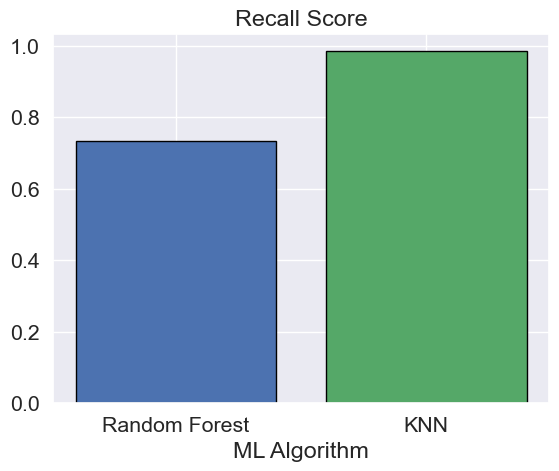

In [50]:
plt.title('Recall Score')
plt.xlabel('ML Algorithm')

algo_recall["KNN"]= recall_dict['133']
recall = algo_recall.values()
print(recall)
x_axis = algo_recall.keys()
print(x_axis)
plt.bar(x_axis, recall,edgecolor = 'black', label = "recall", color=['b', 'g'])

plt.savefig('Recall_comparison.png')
plt.show()

In [52]:
import io
import random
import matplotlib.pyplot as plt
from flask import Flask, render_template, Response
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

app = Flask(__name__)

@app.route('/')
def home():
#     return "Welcome"
    return ('<img src="knn_plot.png" alt="Plot" width="500" height="600">')

@app.route('/knn_plot.png')
def knn_plot_png():
    fig_knn = knn_accuracy()
    output = io.BytesIO()
    FigureCanvas(fig_knn).print_png(output)
    return Response(output.getvalue(), mimetype='image/png')

def knn_accuracy():
    figure, axis = plt.subplots(1, 2)
#     figure = Figure()
#     axis = figure.add_subplot(1, 2)    
    models = [100, 111, 122, 133, 144, 155]
    y1 = [99, 100, 122, 133, 144, 155]
    y2 = [100, 100, 122, 133, 144, 155]
    y3 = [90, 90, 122, 133, 144, 155]

    # For F1_score
    axis[0].plot(models, y1, label = "F1", linestyle="-")
    axis[0].legend()
    axis[0].set_title("F1_score")

    # For Accuracy/Precision
    axis[1].plot(models, y2, label = "accuracy", linestyle="-")
    axis[1].plot(models, y3, label = "precision", linestyle="--")
    axis[1].legend()
    axis[1].set_title("Accuracy/Precision")
    return figure

In [ ]:
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
